## Running notes

hyperparameters-set before training process begins,they are not learned/changed during the training,unlike weights and biases.Eg. optimizer types(adam,sgd,RMSprop,poor choice-slow learning),no of epochs,learning rate/step size,batch size(how many images processed per iteration,too large -overfitting),dropout rate(the fraction of neurons dropped during training for regularization),no of layers/encoder depth(not too deep or shallow network)

why-poor hyperparameters leads to slow convergence,unstable training(fluctuates,never converges) and over/underfitting,what it affects------learning behaviour,training complexity,complex landscape

**1.manual search-working with 1 parameter,while keeping others fixed,good for small dataset and few hyoperparameters,but time confusing    
**2.grid search-training model for all possible combination of hp,and the pick
the model with best performing set on the choosen metrics of validation dataset.adv-it is exhaustive,finds best combo,disad-computationally expensive,not feasible for large datasets/networks      
**3.random search-randomly pick hp set from defined set,faster than grid search,thus makes grid search easier,may miss combination if random sampling is unlucky      
**4.autmoatic/Bayesian optimisation-any kind of sorting/algo,suggests parameter based on previous results.First trains model with random combo,then builds probabilistic model which suggests next combo which are very likel to improve metric score(sequence of steps).optuner,raytune.disad-extra dependencies

optimizer-stragtegy used to minimizes loss function.   momentum-gradient speeed and direction,adam-weighted average of past gradients,works well even out of the box,but slightly memeory intensive and sometimes overfits in small dataset

## Task

train unet again for 5 epochs using sgd,adam,rms prop using small and validate on grid using dice,iou and write down which optimizer converged fastest and had cleanest mask.

Using device: cuda
--- Starting Task 1: Optimizer Comparison ---
Scanning trainval split for valid masks...


100%|██████████| 3680/3680 [00:14<00:00, 246.13it/s]


Found 3673 images with valid masks.
Scanning test split for valid masks...


100%|██████████| 3669/3669 [00:14<00:00, 244.67it/s]


Found 3662 images with valid masks.

Training with Adam...

Training with RMSprop...

Training with SGD...


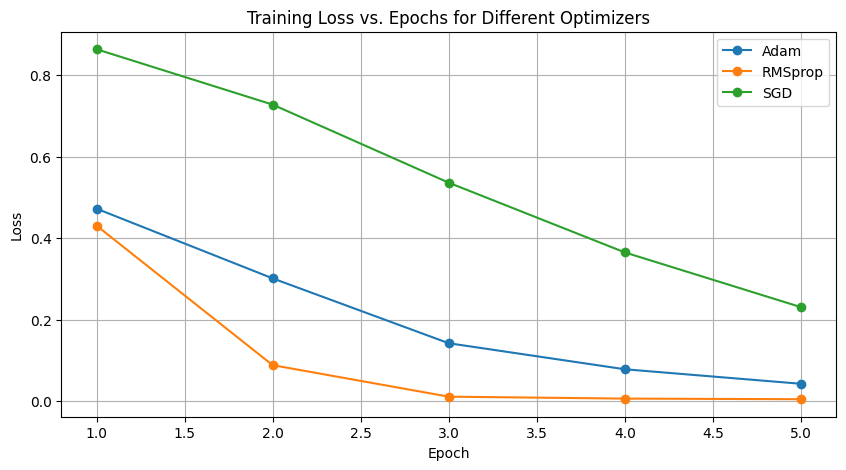

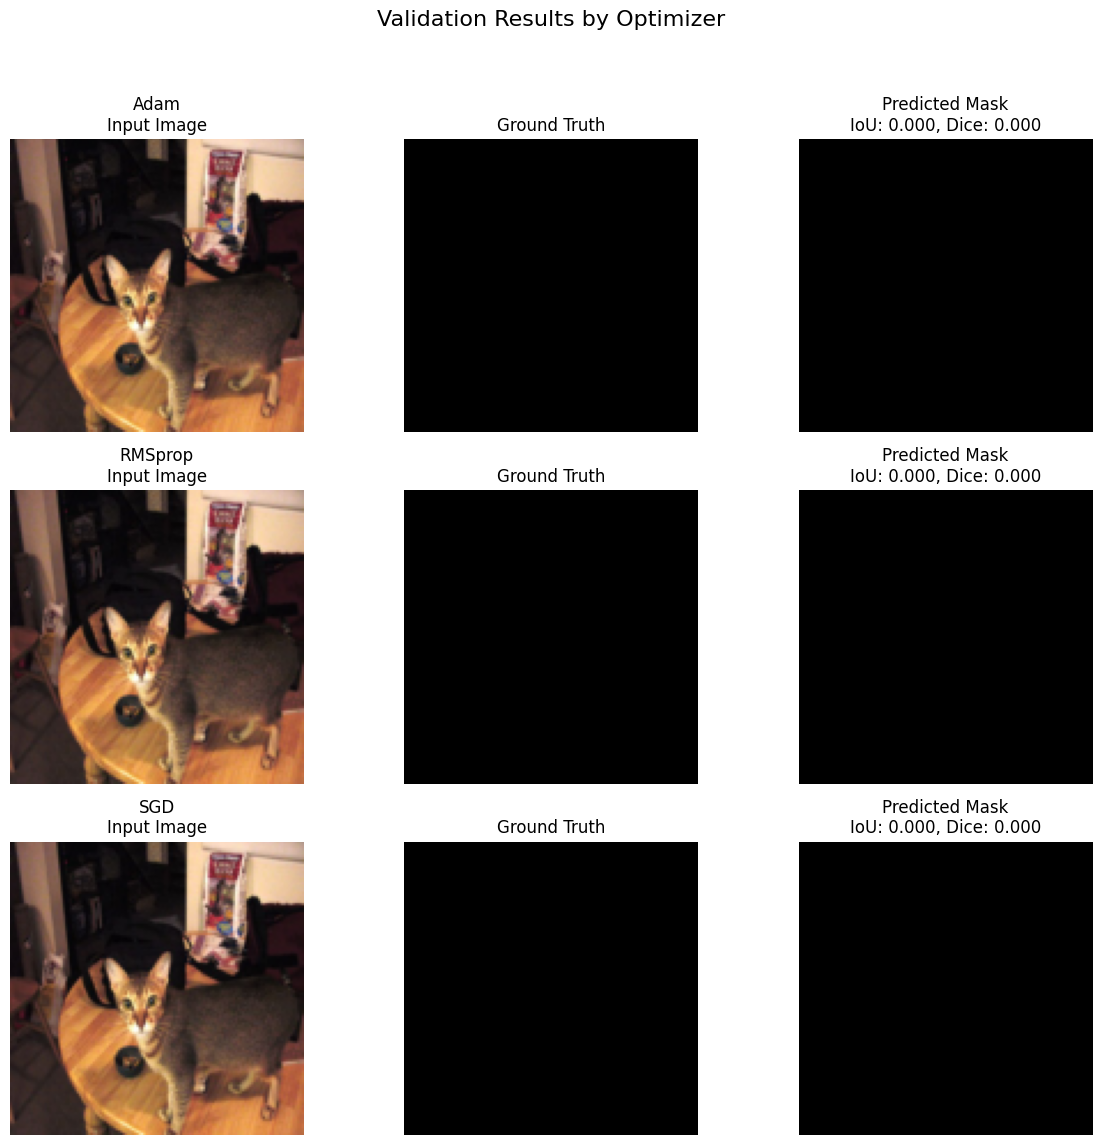

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as T
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set a seed for reproducibility
torch.manual_seed(42)

# --- 1. Define U-Net Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(in_channels, 64); self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = conv_block(64, 128); self.pool2 = nn.MaxPool2d(2, 2)
        self.bottleneck = conv_block(128, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)
        self.output_layer = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.encoder1(x); p1 = self.pool1(e1)
        e2 = self.encoder2(p1); p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        d2 = self.decoder2(torch.cat((e2, self.upconv2(b)), dim=1))
        d1 = self.decoder1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return self.output_layer(d1)

# --- 2. Define Dataset with Integrated Pre-Filtering ---
class PetDatasetWrapper(Dataset):
    def __init__(self, split='trainval', num_samples=5, img_size=128):
        self.img_size = img_size
        # This will download the dataset ONCE if it's not in the './data' folder
        base_dataset = OxfordIIITPet(root="./data", split=split, download=True, target_types="segmentation")

        # --- Pre-filter for valid masks to prevent loading empty ones ---
        print(f"Scanning {split} split for valid masks...")
        self.valid_indices = []
        for i in tqdm(range(len(base_dataset))):
            _, mask = base_dataset[i]
            # Check the raw PIL mask image for the 'pet' class (value 1)
            if 1 in mask.getdata():
                self.valid_indices.append(i)

        if not self.valid_indices:
            raise RuntimeError(f"No valid masks found in the {split} dataset. Check data integrity.")

        print(f"Found {len(self.valid_indices)} images with valid masks.")

        self.base_dataset = base_dataset
        self.num_samples = min(num_samples, len(self.valid_indices))

        self.transforms = T.Compose([
            T.Resize((img_size, img_size), antialias=True),
            T.ToImage(), T.ToDtype(torch.float32, scale=True)
        ])
        self.image_norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Use the pre-filtered list of valid indices
        actual_idx = self.valid_indices[idx]
        image, mask = self.base_dataset[actual_idx]

        image, mask = self.transforms(image, mask)

        # Convert trimap (1=pet, 2=border, 3=background) to a binary mask
        mask = (mask == 1).to(torch.float32)

        return self.image_norm(image), mask

# --- 3. Define Training and Utility Functions ---
def iou_dice(pred, true, threshold=0.5):
    pred_bin = (pred > threshold).float()
    true_bin = (true > 0.5).float()
    inter = (pred_bin * true_bin).sum()
    union = pred_bin.sum() + true_bin.sum() - inter + 1e-7
    iou_score = (inter / union).item()
    dice_score = (2 * inter / (pred_bin.sum() + true_bin.sum() + 1e-7)).item()
    return iou_score, dice_score

def train_model(config, train_loader, val_loader, device):
    model = UNet().to(device)
    if config['optimizer'] == 'Adam': optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    elif config['optimizer'] == 'RMSprop': optimizer = optim.RMSprop(model.parameters(), lr=config['lr'])
    else: optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

    criterion = nn.BCEWithLogitsLoss()
    loss_history = []

    for epoch in range(config['epochs']):
        model.train()
        epoch_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(train_loader))

    model.eval()
    val_images, val_masks = next(iter(val_loader))
    val_images, val_masks = val_images.to(device), val_masks.to(device)
    with torch.no_grad():
        pred_masks = torch.sigmoid(model(val_images))
    iou_score, dice_score = iou_dice(pred_masks, val_masks)

    inv_normalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    val_images_plot = inv_normalize(val_images).cpu()

    return loss_history, iou_score, dice_score, val_images_plot, val_masks.cpu(), pred_masks.cpu()

# --- 4. Main Execution Block ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print("--- Starting Task 1: Optimizer Comparison ---")

# --- Create small, valid datasets for the task ---
train_dataset = PetDatasetWrapper(split='trainval', num_samples=5)
val_dataset = PetDatasetWrapper(split='test', num_samples=5)
val_loader_t1 = DataLoader(val_dataset, batch_size=5, shuffle=False)

optimizers_to_compare = ['Adam', 'RMSprop', 'SGD']
results_t1 = {}
config_t1 = {'lr': 0.01, 'epochs': 5, 'batch_size': 3}

for opt_name in optimizers_to_compare:
    print(f"\nTraining with {opt_name}...")
    config_t1['optimizer'] = opt_name
    train_loader = DataLoader(train_dataset, batch_size=config_t1['batch_size'], shuffle=True)
    results_t1[opt_name] = train_model(config_t1, train_loader, val_loader_t1, device)

# --- Plotting and Displaying Results ---
plt.figure(figsize=(10, 5))
for opt_name, (loss_hist, _, _, _, _, _) in results_t1.items():
    plt.plot(range(1, config_t1['epochs'] + 1), loss_hist, marker='o', label=opt_name)
plt.title('Training Loss vs. Epochs for Different Optimizers')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

fig, axes = plt.subplots(len(optimizers_to_compare), 3, figsize=(12, 12))
fig.suptitle('Validation Results by Optimizer', fontsize=16)
for i, opt_name in enumerate(optimizers_to_compare):
    _, iou_score, dice_score, val_imgs, true_msks, pred_msks = results_t1[opt_name]
    axes[i, 0].imshow(val_imgs[0].permute(1, 2, 0).clamp(0, 1)); axes[i, 0].set_title(f"{opt_name}\nInput Image")
    axes[i, 1].imshow(true_msks[0].squeeze(), cmap='gray'); axes[i, 1].set_title("Ground Truth")
    axes[i, 2].imshow(pred_msks[0].squeeze() > 0.5, cmap='gray'); axes[i, 2].set_title(f"Predicted Mask\nIoU: {iou_score:.3f}, Dice: {dice_score:.3f}")
    for ax in axes[i]: ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()